# Exploring overlaps

This notebook has some initial exploration of overlaps between the EHR prescription sources and the DM+D. Much of what is here is replicated in the `pres-db-stats` script. However, I have left this here as it might be useful for reference and further exploration.

In [1]:
from prescription_db import orm, stats
from snomed_ct import common
from upsetplot import from_indicators, plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy

In [2]:
# Display all pandas columns
from IPython.display import display
pd.options.display.max_columns = None
width = 7
height = 7
dpi = 200

# Make the graphs bigger
plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams['figure.dpi'] = dpi

Connect to the database and create a session. This version has the DM+D upto the second week of May 2023.

In [3]:
engine = sqlalchemy.create_engine('sqlite:////data/prescription_db/dbs/pres-db-dmd_2023_5_2.db')
sm = sqlalchemy.orm.sessionmaker(bind=engine)
session = sm()

## Counts of sources in the DM+D
The query below provides the strings that occur in various input sources and their names, with the indicator if the string was derinved from the DM+D.

In [4]:
q = session.query(
    orm.PresString.pres_str_id,
    orm.PresString.is_dmd,
    orm.PresString.pres_str_name,
    orm.DataSource.data_source_id,
    orm.DataSource.data_source_pretty
).join(
    orm.PresStringOccurs,
    orm.PresString.pres_str_id == orm.PresStringOccurs.pres_str_id
).join(
    orm.SourceVersion,
    orm.SourceVersion.source_version_id == orm.PresStringOccurs.source_version_id
).join(
    orm.DataSource,
    orm.DataSource.data_source_id == orm.SourceVersion.data_source_id
)

In [5]:
df = pd.DataFrame(q)

In [6]:
df.head()

pres_str_id  is_dmd                                      pres_str_name  \
0            1    True  Generic COVID-19 Vaccine Bimervax (recombinant...   
1            2    True  Fludrocortisone 100micrograms/ml oral solution...   
2            3    True  Methylthioninium chloride (methylene blue) 50m...   
3            4    True  Patent blue V 50mg/2ml (2.5%) solution for inj...   
4            5    True  Pipotiazine 25mg/1ml solution for injection am...   

   data_source_id data_source_pretty  
0               1               DM+D  
1               1               DM+D  
2               1               DM+D  
3               1               DM+D  
4               1               DM+D

The data sources that are present in the data, there is the DM+D and 3 EHR derived data sources.

In [7]:
df.data_source_pretty.unique()

array(['DM+D', 'UK biobank', 'CPRD aurum', 'CPRD gold'], dtype=object)

Get the number of prescription strings that are derived directly from the DM+D

In [8]:
nstrings = pd.DataFrame(df['data_source_pretty'].value_counts())
nstrings.columns = ['counts']

In [9]:
nstrings

counts
DM+D        298583
UK biobank   80679
CPRD gold    79530
CPRD aurum   59416

Now get the number and % of strings from each source that occur in the DM+D

In [10]:
in_dmd = pd.DataFrame(df.groupby(['data_source_pretty', 'is_dmd']).count()['pres_str_id'])
in_dmd.columns = ['counts']

In [11]:
in_dmd['% DM+D'] = np.divide(*in_dmd.align(nstrings, level=0)) * 100

In [12]:
in_dmd

counts      % DM+D
data_source_pretty is_dmd                    
CPRD aurum         False    11515   19.380302
                   True     47901   80.619698
CPRD gold          False    19459   24.467497
                   True     60071   75.532503
DM+D               True    298583  100.000000
UK biobank         False    59838   74.167999
                   True     20841   25.832001

We can see the the UK Biobank is in a bad way with only ~26% of the prescription strings overlapping with the DM+D

Finally, we will get a count of the number unique strings (collapsed across sources) that are not in the DM+D

In [13]:
# Repeated across sources
df.loc[df.is_dmd == False, 'pres_str_id'].shape[0]

90812

In [14]:
# Unique across all sources
df.loc[df.is_dmd == False, 'pres_str_id'].nunique()

88668

It is interesting that there is not that many strings that are not in the DM+D that are shared across sources, I am not sure why that is. It could be different definitions used but the underlaying codes are the same.

I will have a quick look at the overlaps between the various EHR resources. First I will aggregae into a boolean matrix.

In [15]:
ps = pd.DataFrame(df.loc[df.data_source_id > 1].pres_str_id.unique(), columns=['pres_str_id']).set_index('pres_str_id')
for i in df.data_source_pretty.unique():
    if i == "DM+D":
        continue
    x = df.loc[df.data_source_pretty == i, ['pres_str_id', 'data_source_pretty']].set_index('pres_str_id')
    x['data_source_pretty'] = True
    x.columns = [i]
    ps = ps.merge(x, left_index=True, right_index=True, how='left')
ps[ps.isnull()] = False

Now plot the overlaps between the the various EHR resources, as expected a significant proportion are not observed in anything else.

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

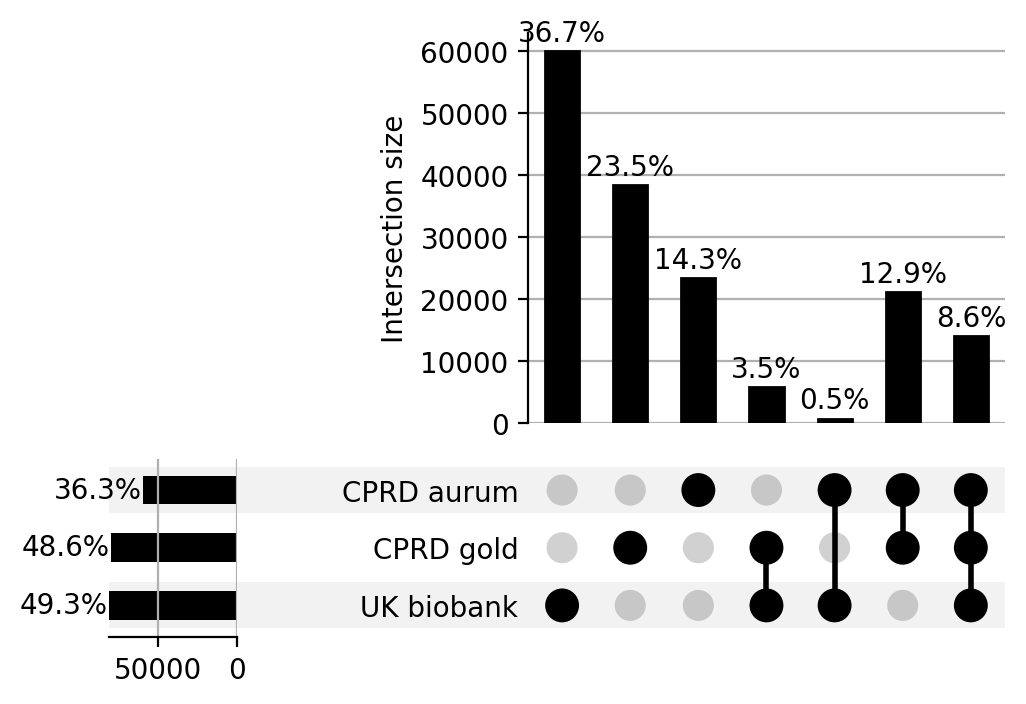

In [16]:
types = from_indicators(ps.columns, data=ps).iloc[:,0]
plot(types, subset_size='count', show_percentages=True)

## Counts of sources that have codes associated with them
Here we will look at the sources that have codes associated with them and where those codes are derived from. First query the codes and there data sources from the database. we will also get some of the code QC stats and code namesspaces/organisations.

In [17]:
q = session.query(
    orm.PresStringCode.pres_str_id,
    orm.PresStringCode.pres_str_code,
    orm.PresStringCode.is_verhoeff_valid,
    orm.PresStringCode.check_digit,
    orm.PresStringCode.namespace_id,
    orm.PresStringCode.organisation,
    orm.DataSource.data_source_id,
    orm.DataSource.data_source_pretty
).join(
    orm.SourceVersion,
    orm.SourceVersion.source_version_id == orm.PresStringCode.source_version_id
).join(
    orm.DataSource,
    orm.DataSource.data_source_id == orm.SourceVersion.data_source_id
)

In [18]:
codes = pd.DataFrame(q)

### Overlaps of codes with prescription strings
First we will ask the question of which prescription strings have a code associated with them and roughly how many codes are associated with a prescription string.

In [19]:
str_with_code = pd.DataFrame(
    codes[['pres_str_id', 'data_source_pretty']].
    drop_duplicates().
    value_counts('data_source_pretty'),
    columns=['str_with_code']
)

In [20]:
code_with_str = pd.DataFrame(
    codes[['pres_str_id', 'data_source_pretty']].
    value_counts('data_source_pretty'),
    columns=['code_with_str']
)

In [21]:
code_count = pd.concat([nstrings, str_with_code, code_with_str], axis=1)
code_count['% str_with_code'] = (code_count['str_with_code']/code_count['counts'])*100
code_count['codes_per_str'] = code_count['code_with_str']/code_count['str_with_code']

In [22]:
code_count

counts  str_with_code  code_with_str  % str_with_code  \
DM+D        298583         298583         425041       100.000000   
UK biobank   80679          46178          49875        57.236703   
CPRD gold    79530          72338          73618        90.956872   
CPRD aurum   59416          59416          59432       100.000000   

            codes_per_str  
DM+D             1.423527  
UK biobank       1.080060  
CPRD gold        1.017695  
CPRD aurum       1.000269

Once again UK biobank has minimal codes associated with the strings, it would be good to stratify this by strings in the DM+D, I might do that in future. CPRD Aurum is in pretty good shape and CPRD Gold has ~90% of strings having a code associated with them as well.

### Code validity
We perform Verhoeff function validity checks for each code that is imported. So we can look in each of the data sources and check out how many codes pass/fail the Verhoeff validity check.

In [23]:
code_validity = pd.DataFrame(
    codes[['data_source_pretty', 'is_verhoeff_valid']].
    value_counts()
)

In [24]:
code_validity

0
data_source_pretty is_verhoeff_valid        
DM+D               True               425041
CPRD aurum         True                59432
UK biobank         True                49818
CPRD gold          True                37652
                   False               35966
UK biobank         False                  57

I am amazed at how many GPRD gold codes fail validity, almost 50%. This is pretty bad and indicates some systematic error. I just want to manually check a few things to make sure that this has not happened on import. First, we get the bad codes where the presscription code is actually defined

In [25]:
bad_codes = codes.loc[(codes.is_verhoeff_valid == False) & (codes.pres_str_code != 0)].copy()
bad_codes.head()

pres_str_id       pres_str_code  is_verhoeff_valid  check_digit  \
534358       316260  120525001000027100              False            0   
534375       322550  182975001000027100              False            0   
534377       345053   33995001000027108              False            8   
534400       299656   80725001000027104              False            4   
534405        23055   14607911000001100              False            0   

        namespace_id         organisation  data_source_id data_source_pretty  
534358       1000027  In Practice Systems               4          CPRD gold  
534375       1000027  In Practice Systems               4          CPRD gold  
534377       1000027  In Practice Systems               4          CPRD gold  
534400       1000027  In Practice Systems               4          CPRD gold  
534405       1000001      NHS Digital, UK               4          CPRD gold

Now I will manually query one example from the database to make sure pandas has not mashed them. From the results below, it all looks good.

In [26]:
for row in session.query(orm.PresStringCode).filter(orm.PresStringCode.pres_str_code == 33995001000027108):
    print(row)

<PresStringCode(pres_str_code_id=534378, pres_str_id=345053, source_version_id=422, pres_str_code=33995001000027108, is_dmd=False, is_verhoeff_valid=False, check_digit=8, partition_id=10, has_namespace=True, code_type=CONCEPT, is_partition_valid=True, namespace_id=1000027, is_namespace_valid=True, organisation=In Practice Systems)>


I also, went back to the CPRD gold source file and manually checked the following code IDs, they were all present in the file, so I do not think this is an import issue.

* 34682311000001100
* 120525001000027100
* 33995001000027108

These were grepped out with `zgrep -w "<CODE>"`. Finally, I will go back to the orginal Verhoeff function and calculate the check digit and check against the code check digit.

In [27]:
bad_codes['verhoeff_code'] = bad_codes['pres_str_code'].apply(
    lambda x: common.Verhoeff.calculate(str(x)[:-1])
)

In [28]:
bad_codes['match'] = bad_codes.check_digit == bad_codes.verhoeff_code
bad_codes['match'].value_counts()

False    35966
Name: match, dtype: int64

We get the same result as before, so I am pretty sure these are bad from the CPRD source file. Finally, a quick check of the bad UK biobank codes, I think these were all 0 but I will just make sure below.

In [29]:
codes.loc[(codes.is_verhoeff_valid == False) & (codes.data_source_pretty == "UK biobank")].pres_str_code.nunique()

1

### Namespace IDs of valid codes
Now we will explore what organisation the valid Snomed codes come from. This will be stratified by being present or absent from the DM+D and by data source.

In [30]:
strs = df[['pres_str_id', 'is_dmd', 'data_source_id']].drop_duplicates()

In [31]:
strs

pres_str_id  is_dmd  data_source_id
0                 1    True               1
1                 2    True               1
2                 3    True               1
3                 4    True               1
4                 5    True               1
...             ...     ...             ...
518203         8952    True               4
518204       103278    True               4
518205       128314    True               4
518206       137186    True               4
518207       158989    True               4

[518208 rows x 3 columns]

In [32]:
df = strs.merge(
    codes,
    left_on=['pres_str_id', 'data_source_id'],
    right_on=['pres_str_id', 'data_source_id'],
    how='left'
)

In [33]:
df = df.loc[df.is_verhoeff_valid == True]

In [34]:
cc = pd.DataFrame(df.groupby(['data_source_pretty', 'is_dmd', 'organisation']).count()['pres_str_id'])
cc.columns = ['# codes']
cc

# codes
data_source_pretty is_dmd organisation                                         
CPRD aurum         False  EMIS                                            11529
                          EMIS (Egton Medical Information Systems Ltd)        1
                          NHS Digital, UK                                     1
                   True   EMIS                                            47901
CPRD gold          False  In Practice Systems                              2829
                          UNKNOWN                                            55
                   True   In Practice Systems                                10
                          NHS Digital, UK                                 32022
                          SNOMED International                             2734
                          UNKNOWN                                             2
DM+D               True   NHS Digital, UK                                418512
                          SNOMED International                             6529
UK biobank         False  In Practice Systems                             13949
                          NHS Digital, UK                                 16230
                          SNOMED International                            11051
                   True   In Practice Systems                                38
                          NHS Digital, UK                                  6396
                          SNOMED International                             2154

So this is a mixed bag, we can see that the DM+D are all Snomed or NHS derived codes, which is as we would expect. So this is a good QC. For CPRD aurum, most of the codes that have strings that overlap DM+D are derived from EMIS, with about 1/5th not having strings in the DM+D. For CPRD gold the strings that are in the DM+D are largely NHS/Snomed, a bit different from aurum. My guess is that this explains the aparent lack of overlap of strings between the sources, with the aurum ones coming from a different source to gold. The UK biobank is again a bit nasty, as the strings that do not overlap the DM+D are being derived from 3 sources in roughly equal measure. However, you might expect the NHS/Snomed sources which account for 2/3 of the non-DM+D strings to have match in the DM+D, this is strange. So, a couple of possibilities regarding UK Biobank:

1. There are more truncated strings than I realise, so I found ~2,700 by the presence of an ... at the end, however, there could be a lot more from the counts above.
2. A lot of the UK Biobank strings date from before 2014, in which case they should match into the Snomed CT which goes back to 2004 for the NHS and 2002 for the international edition.

So I will do a quick analysis of the overlaps with SnomedCT to have a look.

First get all the prescription strings that exist in SnomedCT

In [ ]:
q = session.query(
    orm.PresStringSnomed.pres_str_id,
    sqlalchemy.literal(True)
).filter(
    orm.PresStringSnomed.code_match == False
).group_by(
    orm.PresStringSnomed.pres_str_id
)
snomed = pd.DataFrame(q, columns=['pres_str_id', 'in_snomed'])

Now generate a dataset of prescription strings that do not occur in the DM+D and indicate if they are in SnomedCT

In [ ]:
no_dmd_snomed = df.loc[df.is_dmd == False].merge(
    snomed, 
    left_on='pres_str_id',
    right_on='pres_str_id',
    how='left'
)
no_dmd_snomed.loc[no_dmd_snomed.in_snomed.isnull(), 'in_snomed'] = False

Now stratify based on EHR source, is it in snomed and by namespace

In [ ]:
cc = pd.DataFrame(no_dmd_snomed.groupby(['data_source_pretty', 'in_snomed', 'organisation']).count()['pres_str_id'])
cc.columns = ['# codes']
cc

So from the results above, it does not look like a date issue, unless pre-2002. Of the strings that are not derived from the DM+D, only 206 can be recovered by looking for them in Snomed descriptions. Most of the UK biobank NHS/Snomed codes that are not in the DM+D are also absent from Snomed. So, I can't rule out that these are really old my hunch is that there are some other issues with them. 